In [56]:
from generate_maps import load_s3dis_point_cloud, get_topologial_map

file_path = 'data/noXYZ_area_5a_no_xyz/area_5a/3d/pointcloud.mat'  
point_sum_points, point_sum_colors, scene_names = load_s3dis_point_cloud(file_path)
print("success load!")


Keys in the .mat file: ['Area_5a']
Processing conferenceRoom_1...
Processing conferenceRoom_2...
Processing conferenceRoom_3...
Processing hallway_1...
Processing hallway_2...
Processing hallway_3...
Processing hallway_4...
Processing hallway_5...
Processing hallway_6...
Processing lobby_1...
Processing hallway_7...
Processing hallway_8...
Processing hallway_9...
Processing hallway_10...
Processing hallway_11...
Processing hallway_12...
Processing hallway_13...
Processing hallway_14...
Processing hallway_15...
Processing office_1...
Processing office_2...
Processing office_3...
Processing office_4...
Processing office_5...
Processing office_6...
Processing office_7...
Processing office_8...
Processing office_9...
Processing office_10...
Processing office_11...
Processing office_12...
Processing office_13...
Processing office_14...
Processing office_15...
Processing office_16...
Processing office_17...
Processing office_18...
Processing office_19...
Processing office_20...
Processing of

In [90]:
for i, name in enumerate(scene_names):
    if "lobby" in name:
        del point_sum_points[i]
        del point_sum_colors[i]
        del scene_names[i]

In [91]:
import generate_maps
import importlib
importlib.reload(generate_maps)

top_view_map, obstacle_map, separate_obstacle_map, all_centers = generate_maps.get_top_view_map(point_sum_points, point_sum_colors, scene_names, resolution=0.02)


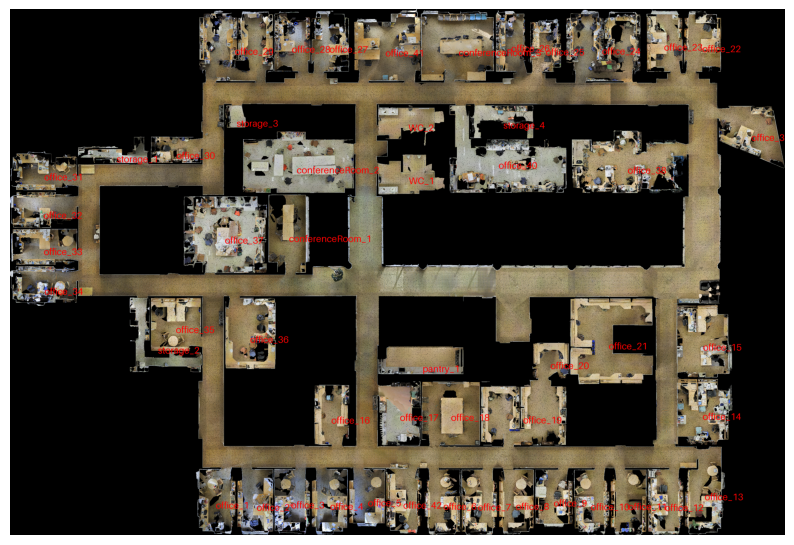

In [92]:
import path_finding
importlib.reload(path_finding)
import matplotlib.pyplot as plt

top_view_map_with_name = path_finding.write_scene_name(top_view_map, all_centers)
plt.figure(figsize=(10, 8)) 
plt.imshow(top_view_map_with_name)
plt.axis('off')  # 隐藏坐标轴
plt.show()

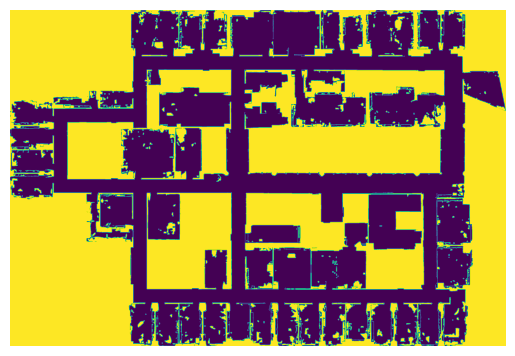

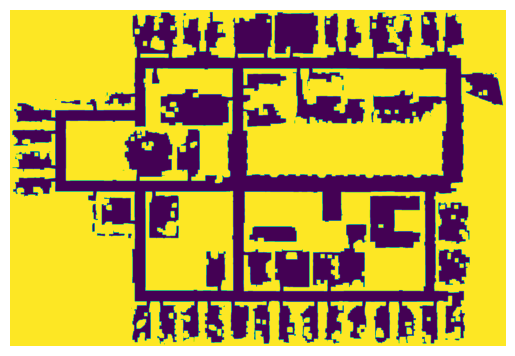

In [93]:
import cv2
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(20, 20))
ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)


plt.imshow(obstacle_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

plt.imshow(ob_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [6]:
importlib.reload(generate_maps)
# build topo map
# G = generate_maps.get_topologial_map(point_sum_points, scene_names)
# graph_show(G)


<module 'generate_maps' from '/home/ybg/Project/Hidden-Info-Nav/generate_maps.py'>

success load!


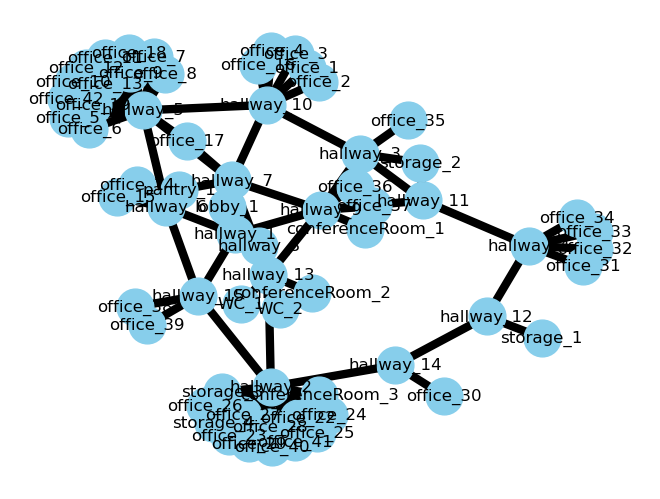

In [88]:

import os
import numpy as np
import pickle

filename = "5a"

# print('Saving model to {}...'.format("saved_maps/"))
# if not os.path.exists("saved_maps/"):
#     os.makedirs("saved_maps/")
    
# graph_serialized = pickle.dumps(G)
# np.savez("saved_maps/" + filename +'_arrays.npz', graph=graph_serialized)
# print('Finished.')

file_path = f"saved_maps/{filename}_arrays.npz"  
data = np.load(file_path, allow_pickle=True)
graph_serialized = data['graph'].item()
G_loaded = pickle.loads(graph_serialized)
print("success load!")

G_loaded.remove_edge('WC_2', 'hallway_2')

path_finding.graph_show(G_loaded)

In [87]:
import networkx as nx
import cv2
import numpy as np
from io import BytesIO

importlib.reload(path_finding)

def get_all_candidate_maps(source_node, target_node):
    all_topo_paths = path_finding.get_all_simple_paths(G_loaded, source_node, target_node)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph(all_topo_paths, obstacle_map, all_centers)

    save_directory = f"map_with_path/area_{filename}/{source_node}-{target_node}/"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # show paths in map
    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = np.array(top_view_map_with_name).copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number_for_large(map_with_path, i)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像
        
        map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
    return candidate_map_list, all_geo_paths

In [32]:
importlib.reload(path_finding)
from PIL import Image

def get_metric(source_node, target_node, all_geo_paths):
    
    evaluation_map = path_finding.get_evaulation_map(separate_obstacle_map, source_node, target_node, scene_names, 15)

    office_obstacle_map_array = np.array(separate_obstacle_map)
    office_obstacle_map = np.max(office_obstacle_map_array, axis=0)

    # plt.imshow(evaluation_map)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()

    privacy_value_list = []
    distance_list = []
    for i, geo_path in enumerate(all_geo_paths):
        x_indices, y_indices = zip(*geo_path)
        # print(gaussian_modulation[x_indices[0], y_indices[0]])
        print("value: ", sum(evaluation_map[x_indices, y_indices]))
        print("distance: ", len(geo_path))
        privacy_value_list.append(sum(evaluation_map[x_indices, y_indices]))
        distance_list.append(len(geo_path))
        
    return privacy_value_list, distance_list

All paths from node office_3 to node office_13 :
2 ['office_3', 'office_13']
3 ['office_3', 'hallway_7', 'office_13']
6 ['office_3', 'hallway_3', 'hallway_9', 'hallway_1', 'hallway_6', 'office_13']
8 ['office_3', 'hallway_3', 'hallway_9', 'hallway_13', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13']
10 ['office_3', 'hallway_3', 'hallway_11', 'hallway_4', 'hallway_12', 'hallway_14', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13']
11 ['office_3', 'hallway_3', 'hallway_11', 'hallway_4', 'hallway_12', 'hallway_14', 'hallway_2', 'hallway_13', 'hallway_1', 'hallway_6', 'office_13']
6
[['office_3', 'office_13'], ['office_3', 'hallway_7', 'office_13'], ['office_3', 'hallway_3', 'hallway_9', 'hallway_1', 'hallway_6', 'office_13'], ['office_3', 'hallway_3', 'hallway_9', 'hallway_13', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13'], ['office_3', 'hallway_3', 'hallway_11', 'hallway_4', 'hallway_12', 'hallway_14', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13']]
['office_3', 'of

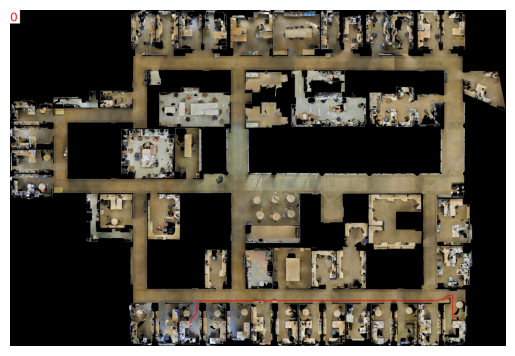

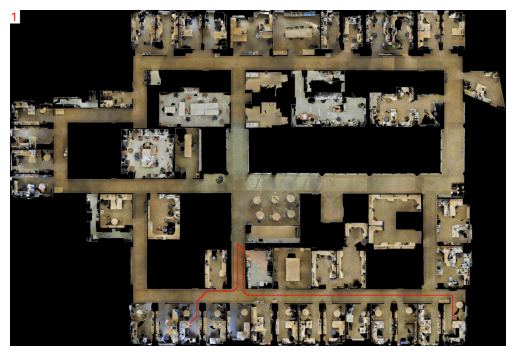

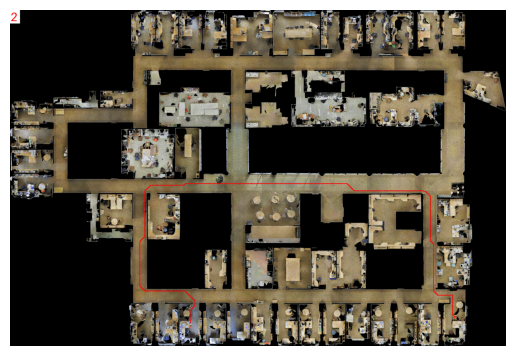

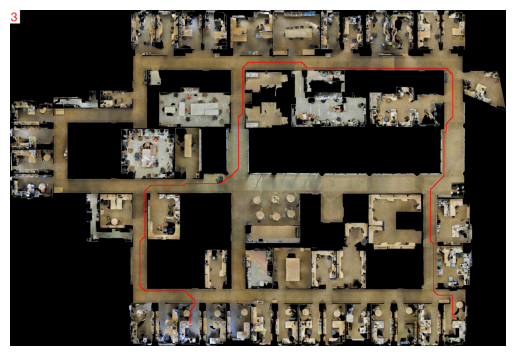

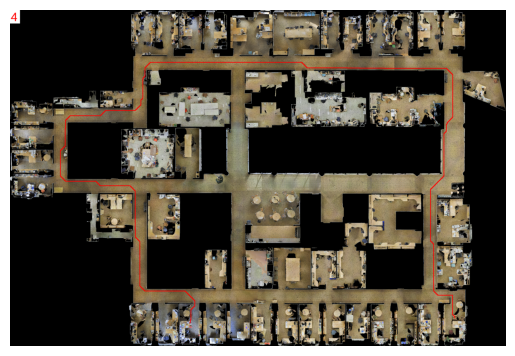

value:  1321.9509323707075
distance:  2009
value:  1221.1605540028252
distance:  2580
value:  1089.1935477763366
distance:  3981
value:  1784.7496582277881
distance:  5592
value:  2222.6230999586915
distance:  6571
gpt-4o response: 
{
    "observation": "Analyzing the top-view maps for the optimal path to transport an emergency file between offices, each path is assessed based on its route through the office environment.",
    "reason": "Path 0 should be selected because it offers a route that minimizes exposure to densely populated office areas, thereby reducing the risk of human interference and ensuring quicker and safer delivery. It directly traverses along the periphery of the office layout, mostly avoiding central office clusters. Paths 1, 2, 3, and 4, while viable, pass through more central office areas which could potentially delay the transportation due to higher human activity and interaction.",
    "self-critique": "While Path 0 is the shortest and least disruptive, a more d

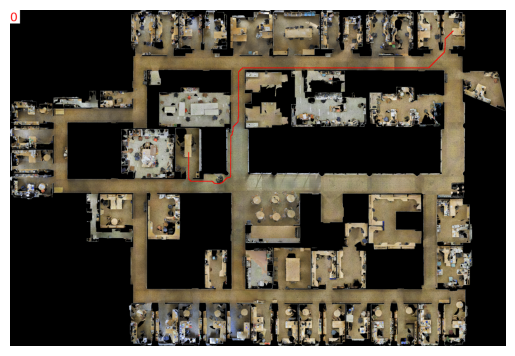

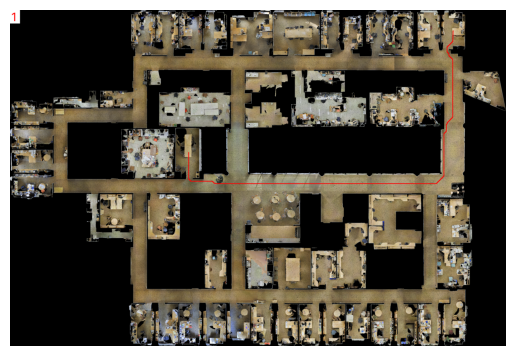

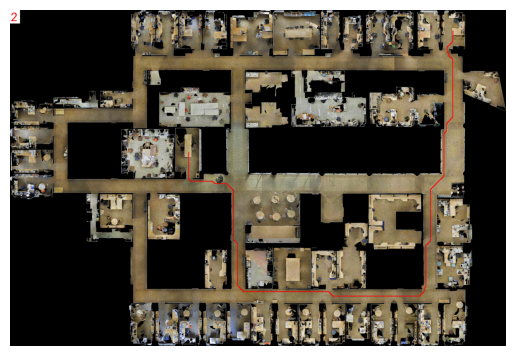

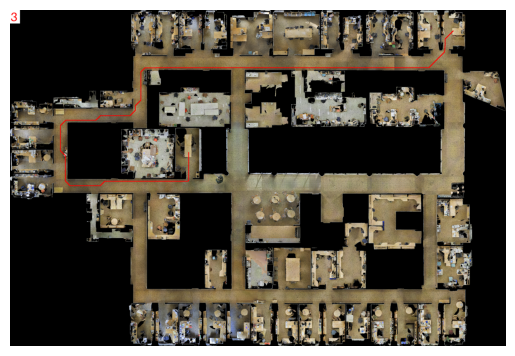

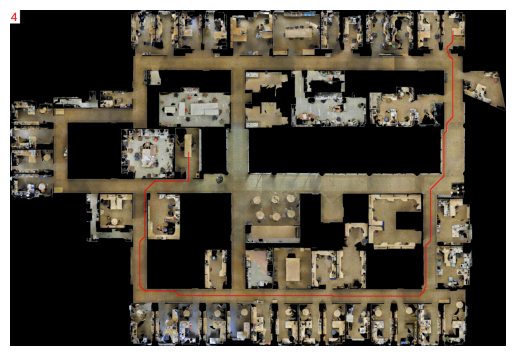

value:  576.017755804837
distance:  2680
value:  215.92951151640887
distance:  2859
value:  1436.0862966376508
distance:  4109
value:  1160.64912804158
distance:  4321
value:  1881.4624084113623
distance:  4766
gpt-4o response: 
{
    "observation": "The task involves analyzing paths from one office to another office, ensuring the emergency file is transported quickly and securely. The maps provided show five different paths, each marked with a unique red line and number. Each path traverses through various office layouts, potentially encountering different levels of human activity and environmental features.",
    "reason": "Path 1 should be selected because it offers a direct route that minimizes exposure to densely populated office areas, thus reducing the risk of the emergency file being delayed or compromised. Paths 0, 2, 3, and 4, while also connecting the offices, pass through more crowded sections or take a longer route which could delay the delivery in an emergency situation."

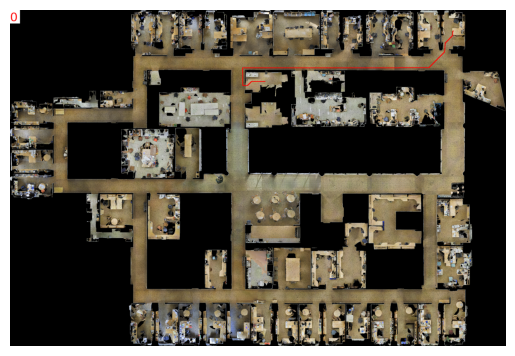

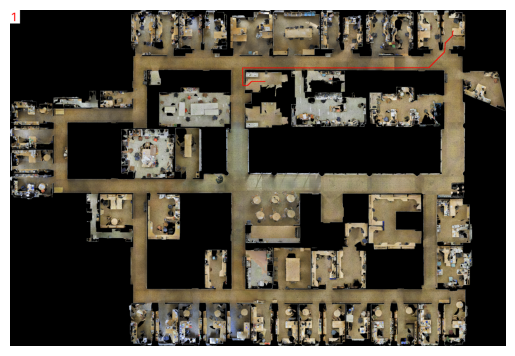

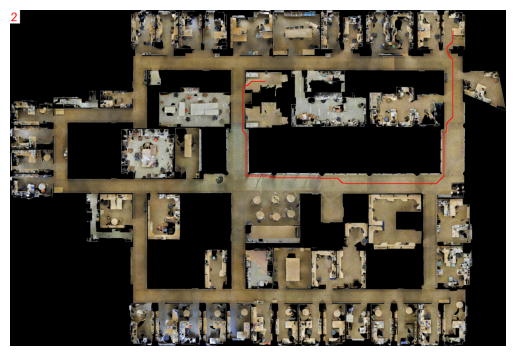

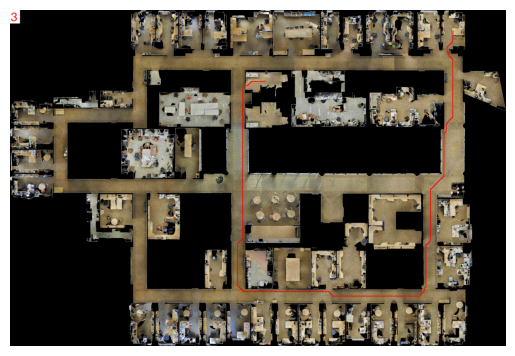

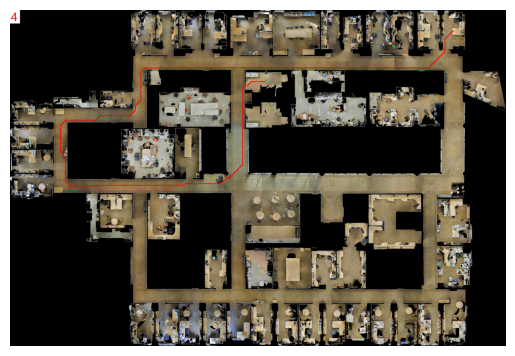

value:  466.9606250984457
distance:  1760
value:  466.9606250984457
distance:  1760
value:  276.7493696059591
distance:  3034
value:  1510.7688528887147
distance:  4465
value:  1363.4534217586497
distance:  5156
gpt-4o response: 
{
    "observation": "The task involves selecting a path that minimizes exposure to densely populated office areas to enhance privacy and speed, considering the emergency nature of the file being transported.",
    "reason": "Path 2 should be accepted because it is the most direct route while avoiding the central, densely populated office areas, which could potentially slow down the delivery due to human activity and interactions. Path 0, 1, 3, and 4, in contrast, traverse more central office areas, increasing the risk of delays and exposure to more people. Path 2 also appears to utilize peripheral corridors, which are likely to be less crowded, ensuring a quicker and more secure delivery.",
    "self-critique": "While Path 2 is optimal in terms of privacy and

In [12]:
import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)

num_samples = 5
navigation_instruct1 = "send a secret file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"
navigation_instruct4 = "send an emergency file from an office to another office"

source_nodes = ["office_3", "office_22", "office_22"]
target_nodes = ["office_13", "conferenceRoom_1", "WC_2"]

total_shortest_score = 0
total_shortest_distance = 0
total_privacy_score = 0
total_privacy_distance = 0
for source_node, target_node in zip(source_nodes, target_nodes):
    candidate_map_list, all_geo_paths = get_all_candidate_maps(source_node, target_node)
    p_v, dis = get_metric(source_node, target_node, all_geo_paths)
    
    index = dis.index(min(dis))
    total_shortest_score += p_v[index]
    total_shortest_distance += dis[index]
    
    navigation_instruct = navigation_instruct4
    # if "conference" in target_node:
    #     navigation_instruct = navigation_instruct2
    # elif "WC" in target_node:
    #     navigation_instruct = navigation_instruct3
    message = chat_utils.message_prepare(system_prompt.prompt, candidate_map_list, navigation_instruct)
            
    response_message = chat_utils.chat_with_gpt4v(message)
    ground_json = ast.literal_eval(response_message)
    print(ground_json["path_id"])
    index = int(ground_json["path_id"])
    
    # responses = []
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #     future_to_message = {executor.submit(chat_utils.chat_with_gpt4v, message): message for _ in range(num_samples)}
    #     for future in concurrent.futures.as_completed(future_to_message):
    #         prompt = future_to_message[future]
    #         try:
    #             response = future.result()
    #             responses.append(response)
    #         except Exception as exc:
    #             print(f'{prompt} generated an exception: {exc}')

    # id_list = []
    # for i, response in enumerate(responses):
    #     ground_json = ast.literal_eval(response)
    #     id_list.append(int(ground_json["path_id"])) 
    # print(id_list)
            
    # counter = Counter(id_list)

    # index, count = counter.most_common(1)[0]
    total_privacy_score += p_v[index]
    total_privacy_distance += dis[index]
    
    
print("A* baseline result: ")
print("total_shortest_score: ", total_shortest_score)
print("total_shortest_distance: ", total_shortest_distance)

print("PAN baseline result: ")
print("total_privacy_score: ", total_privacy_score)
print("total_privacy_distance: ", total_privacy_distance)
    
    

All paths from node office_3 to node office_13 :
2 ['office_3', 'office_13']
3 ['office_3', 'hallway_7', 'office_13']
6 ['office_3', 'hallway_3', 'hallway_9', 'hallway_1', 'hallway_6', 'office_13']
8 ['office_3', 'hallway_3', 'hallway_9', 'hallway_13', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13']
10 ['office_3', 'hallway_3', 'hallway_11', 'hallway_4', 'hallway_12', 'hallway_14', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13']
11 ['office_3', 'hallway_3', 'hallway_11', 'hallway_4', 'hallway_12', 'hallway_14', 'hallway_2', 'hallway_13', 'hallway_1', 'hallway_6', 'office_13']
6
[['office_3', 'office_13'], ['office_3', 'hallway_7', 'office_13'], ['office_3', 'hallway_3', 'hallway_9', 'hallway_1', 'hallway_6', 'office_13'], ['office_3', 'hallway_3', 'hallway_9', 'hallway_13', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13'], ['office_3', 'hallway_3', 'hallway_11', 'hallway_4', 'hallway_12', 'hallway_14', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13']]
['office_3', 'of

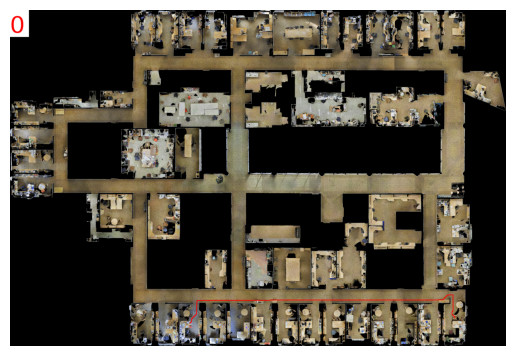

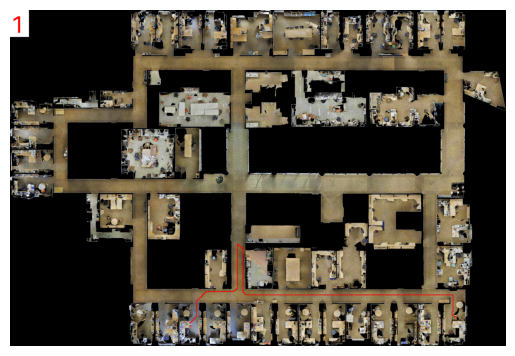

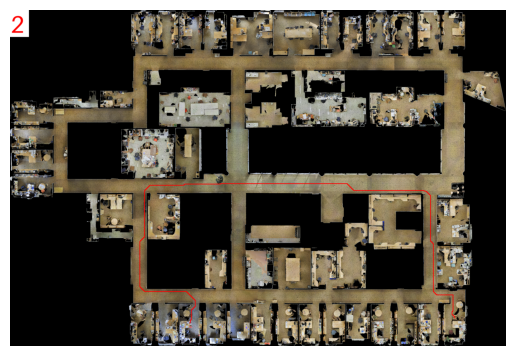

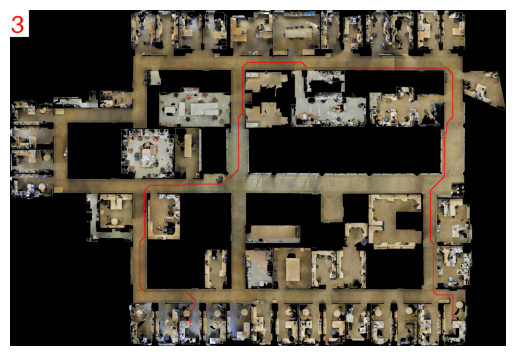

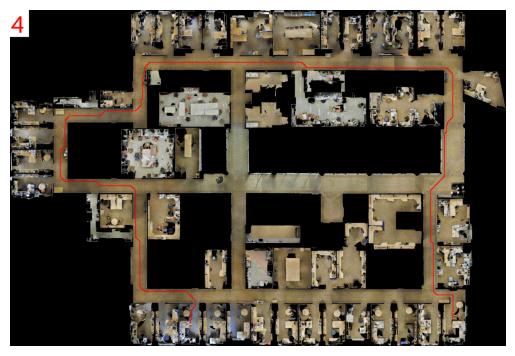

value:  1315.50167422697
distance:  2018
value:  1203.9581284082435
distance:  2600
value:  1097.675281561601
distance:  4010
value:  1807.5631004267286
distance:  5631
value:  2256.031962398242
distance:  6620
gpt-4o response: 
{
    "observation": "Analyze what kind of scenes each path pass through in the top-view maps", 
    "reason": "Considering the requirement to transport a secret file with an emphasis on privacy and safety, Path 4 is the most suitable option. Path 4 manages to mostly avoid high-traffic office areas, reducing the risk of accidental exposure to unauthorized personnel. In contrast, Paths 0 and 1 pass through multiple office areas, increasing the risk of exposure. Path 2, while more secluded than Paths 0 and 1, still traverses a significant number of office spaces compared to Path 4.",
    "self-critique": "While Path 4 is the optimal choice based on the given constraints, it's longer than some other paths, which might not be ideal in terms of time efficiency. Addi

In [96]:
import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)

num_samples = 5
navigation_instruct1 = "send a secret file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"
navigation_instruct4 = "send an emergency file from an office to another office"

# source_nodes = ["office_3", "office_22", "office_39"]
# target_nodes = ["office_13", "conferenceRoom_2", "WC_2"]
source_nodes = ["office_3"]
target_nodes = ["office_13"]

total_shortest_score = 0
total_shortest_distance = 0
total_privacy_score = 0
total_privacy_distance = 0
for source_node, target_node in zip(source_nodes, target_nodes):
    candidate_map_list, all_geo_paths = get_all_candidate_maps(source_node, target_node)
    p_v, dis = get_metric(source_node, target_node, all_geo_paths)
    
    index = dis.index(min(dis))
    total_shortest_score += p_v[index]
    total_shortest_distance += dis[index]
    
    navigation_instruct = navigation_instruct1
    if "conference" in target_node:
        navigation_instruct = navigation_instruct2
    elif "WC" in target_node:
        navigation_instruct = navigation_instruct3
    message = chat_utils.message_prepare(system_prompt.prompt, candidate_map_list, navigation_instruct)
            
    response_message = chat_utils.chat_with_gpt4v(message)
    ground_json = ast.literal_eval(response_message)
    print(ground_json["path_id"])
    index = int(ground_json["path_id"])
    
    # responses = []
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #     future_to_message = {executor.submit(chat_utils.chat_with_gpt4v, message): message for _ in range(num_samples)}
    #     for future in concurrent.futures.as_completed(future_to_message):
    #         prompt = future_to_message[future]
    #         try:
    #             response = future.result()
    #             responses.append(response)
    #         except Exception as exc:
    #             print(f'{prompt} generated an exception: {exc}')

    # id_list = []
    # for i, response in enumerate(responses):
    #     ground_json = ast.literal_eval(response)
    #     id_list.append(int(ground_json["path_id"])) 
    # print(id_list)
            
    # counter = Counter(id_list)

    # index, count = counter.most_common(1)[0]
    total_privacy_score += p_v[index]
    total_privacy_distance += dis[index]
    
    
print("A* baseline result: ")
print("total_shortest_score: ", total_shortest_score)
print("total_shortest_distance: ", total_shortest_distance)

print("PAN baseline result: ")
print("total_privacy_score: ", total_privacy_score)
print("total_privacy_distance: ", total_privacy_distance)

In [75]:
print(obstacle_map[0, 0])

1
